<center>
<img src="https://i.pinimg.com/736x/cf/fa/57/cffa57d6bb324f84e9eecdb340523ae0.jpg" alt="Image" style="margin:auto">
</center>

#### **A portrait is basically a picture or drawing of a person. It's like taking a photo of someone, but instead of using a camera, an artist uses their skills to create a picture by hand.**

# <font color="#B59410">Importing Libraries</font>

In [1]:
import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

2024-04-30 07:02:14.629836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 07:02:14.629931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 07:02:14.736863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <font color="#B59410">Loading the Dataset</font>

#### I have used this dataset as It has only 10k+ images. This was a Subset of the [Oiginal dataset](https://academictorrents.com/details/1d154cde2fab9ec8039becd03d9bb877614d351b) also on [Kaggle dataset](https://www.kaggle.com/datasets/ipythonx/wikiart-gangogh-creating-art-gan) but as i had to train for long and the time constraint i had to go with this as it is a really great dataset.

### Preprocessing the data
**Normalization:** For the data normalization, I will convert the data in the range between 0 to 1. This helps in fast convergence and makes it easy for the computer to do calculations faster. Each of the three RGB channels in the image can take pixel values ranging from 0 to 256. Dividing it by 255 converts it to a range between 0 to 1.

In [2]:
data_path = "../input/art-portraits/Portraits/Portraits"

dataset = keras.utils.image_dataset_from_directory(
    data_path, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 4117 files.


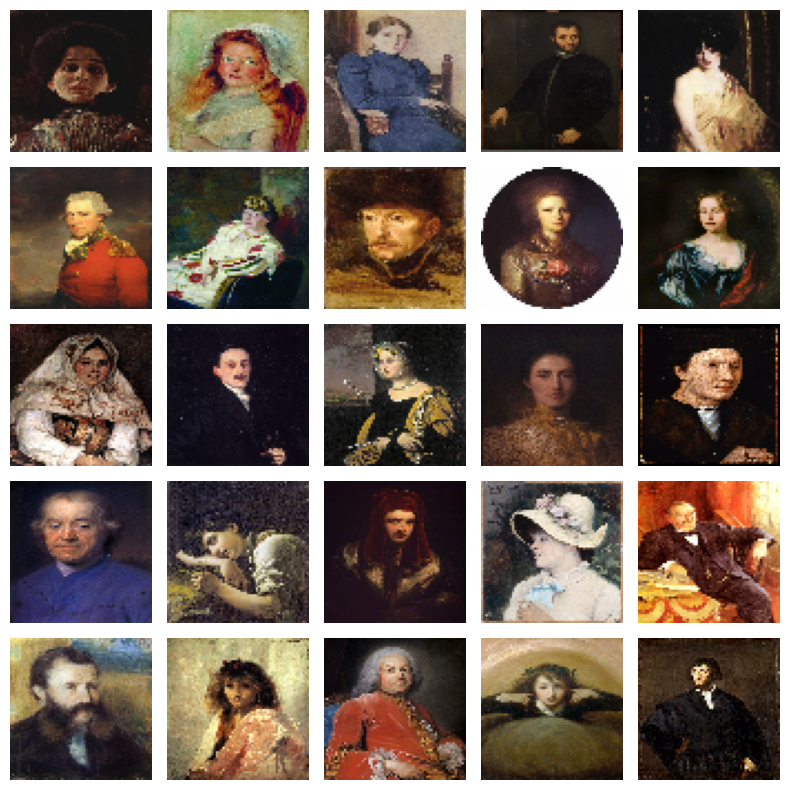

In [3]:
images = next(iter(dataset.take(25)))

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")
    plt.gca().set_aspect('auto')

plt.tight_layout()
plt.show()

# <font color="#B59410">Generator</font>

In a Generative Adversarial Network (GAN), the generator is one of the two neural networks involved in the training process, alongside the discriminator. The generator's main objective is to create realistic data samples, such as images, audio clips, or text, from random noise or a latent space.
<center>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif?raw=true" alt="Image" style="margin:auto">
</center>

In [4]:
latent_dim = 128
generator = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh")
], name="generator")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


#### <font color="red">Note: You might have a question how to create a Generator or discriminator i will explain as much as i know.</font>

### Basic Requirements in a Generator
**1. Input Layer:** This is important as the random noise vectors from the latent space are passed as inputs.

**2. Dense (Fully Connected) Layer:** The dense layer serves as the initial mapping from the low-dimensional latent space to a higher-dimensional feature space. Its purpose is to transform the input noise into a format that can be reshaped into a 3D volume.

**3. Reshape Layer:** The reshape layer reshapes the output of the dense layer into a 3D volume, which can be interpreted as an image-like representation. The size of the reshape operation should match the desired shape of the generated images.

**4. Conv2DTranspose Layers:** Convolutional transpose layers (also known as "deconvolution" or "up-sampling" layers) are used to increase the spatial dimensions of the input volume. They are crucial for generating higher-resolution images from the low-resolution feature maps produced by the preceding layers.

* Kernal_size, strides, padding the values are taken w.r.t that type and size of image you are using. As these are used in training.
***
* The kernel_size parameter specifies the size of the convolutional kernel/filter.

* The strides parameter determines the step size or movement of the convolutional kernel/filter as it slides/spatially moves across the input feature map during the convolution operation.

* The padding parameter determines how the spatial dimensions of the input feature map are preserved or altered during the convolution operation.
***

**5. Activation Functions:**  Leaky ReLU activation functions are commonly used in generator networks.

**6. Final Conv2D Layer:** The final convolutional layer generates the output image. It typically has a single channel for grayscale images or three channels for RGB images.

***
There are two types of activation functions Majorly used for Sigmoid and tanh. But in cases of GAN Models and in general tahn performs much better than a Sigmoid models. [Read more](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)
<center>
<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*f9erByySVjTjohfFdNkJYQ.jpeg" alt="Image" style="margin:auto">
</center>

***

In [5]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,235 (15.19 MB)

 Trainable params: 3,981,443 (15.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

# <font color="#B59410">Discriminator</font>

A discriminator is a crucial component of a Generative Adversarial Network (GAN). Its primary function is to distinguish between real and fake data samples.

* The discriminator's goal is to classify input data samples as either real (coming from the true data distribution) or fake (generated by the generator network).
* By learning to differentiate between real and fake samples, the discriminator provides feedback to the generator, helping it improve its ability to generate more realistic data.

In [6]:
# Create the discriminator
discriminator = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="tanh")
], name="discriminator")

## Basic Requirements in a Discriminator
**1. Input Layer:** It is the entry point for data that defines the shape of the input data that will be fed into the network. It sets the initial shape and size of the data that the network will process.

**2. Convolutional Layers:** These are the fundamental building blocks of a GAN Model. These layers apply filters to input data to extract spatial features. The filters slide over the input data, performing element-wise multiplication and summation operations to produce feature maps.

**3. Flatten Layer:** It is typically used to reshape the output of the last convolutional layer into a 1D vector. This flattening operation is necessary to connect the convolutional layers to fully connected (dense) layers.

**4. Dropout Layer:** Dropout layers are a regularization technique used to prevent overfitting in neural networks. This most important why we use it. 

**5. Dense Layer:**  Dense layers are fully connected layers in which each neuron is connected to every neuron in the previous layer.

#### **Additional layers that could be added:**

**6. BatchNormalization**

**7. MaxPooling2D**

**8. GlobalAveragePooling2D**\

**<font color="red">Note: May Continue in future or you may try it to improve the output.</font>**

In [7]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,057 (2.58 MB)

 Trainable params: 676,161 (2.58 MB)

 Non-trainable params: 896 (3.50 KB)

<img src="https://i.pinimg.com/564x/fe/6a/62/fe6a627c74ce0684da1ee6abbdd1bb80.jpg" alt="Image" style="margin:auto">

# <font color="#B59410">Creating GAN Model</font>

The Below code is taken from the the [keras documentation](https://keras.io/examples/generative/) Just go and have a look at all the Image Generation models it's a great way to start and get a experience if you are new to GAN. Just a little twike might be give otherwise you can get the code from [here](https://keras.io/examples/generative/dcgan_overriding_train_step/)

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

<font color="red">Note: There are many loss functions that can be used to calculate the generator and discriminator loss. But in my case this default one seems to be working better than the others. Yes, i have tried and checked with Wasserstein GAN Loss. for my case it did not do that well. If you want to know more about loss functions you can read [here](https://machinelearningmastery.com/generative-adversarial-network-loss-functions/)</font>

This below code is for my use as this will save all the images generated in every epoch and dispay the generated image after every 20 epochs. Just for me to know how the generator works.

In [9]:
# Define a custom callback to generate and save images after each epoch
class ImageGeneratorCallback(keras.callbacks.Callback):
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.generated_images = []

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        self.generated_images.append(generated_images)
        if (epoch + 1) % 20 == 0 or (epoch + 1) == epochs:
            fig, axs = plt.subplots(6, 6, figsize=(5, 5))
            for i in range(6):
                for j in range(6):
                    axs[i, j].imshow(generated_images[i * 6 + j])
                    axs[i, j].axis('off')
            # Add a subtitle displaying the epoch number
            plt.suptitle(f"Epoch {epoch + 1}/{epochs} - D Loss: {logs['d_loss']:.4f}, G Loss: {logs['g_loss']:.4f}")
            plt.show()

# <font color="#B59410">Training the GAN Model</font>

I tried Hyperparameter Tunning and this is the best till now that i am able to achieve.

Epoch 1/200


I0000 00:00:1714460591.558621      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714460591.579587      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/129 ━━━━━━━━━━━━━━━━━━━━ 95s 469ms/step - d_loss: 1.5249 - g_loss: 0.3445
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - d_loss: 0.6013 - g_loss: 1.1986
Epoch 3/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - d_loss: 0.6721 - g_loss: 0.9409
Epoch 4/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - d_loss: 0.6826 - g_loss: 0.8772
Epoch 5/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - d_loss: 0.6607 - g_loss: 0.8910
Epoch 6/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.7143 - g_loss: 0.9078
Epoch 7/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6827 - g_loss: 0.8652
Epoch 8/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6883 - g_loss: 0.8513
Epoch 9/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - d_loss: 0.7305 - g_loss: 0.9392
Epoch 10/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6762 - g_loss: 0.8820
Epoch 11/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - d_loss: 0.6805 - g_loss: 0.8905
Epoch 12/200
129/129

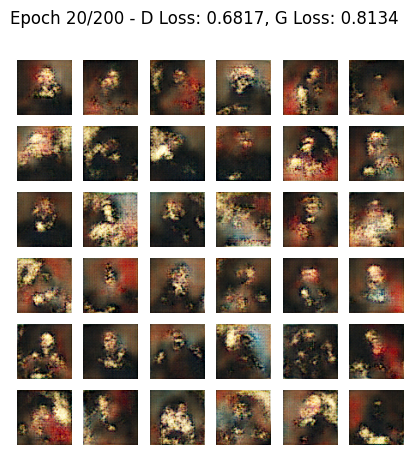

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - d_loss: 0.6772 - g_loss: 0.8036
Epoch 21/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6814 - g_loss: 0.7943
Epoch 22/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6780 - g_loss: 0.8007
Epoch 23/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6796 - g_loss: 0.8172
Epoch 24/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6720 - g_loss: 0.8098
Epoch 25/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6721 - g_loss: 0.8121
Epoch 26/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6762 - g_loss: 0.8317
Epoch 27/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6679 - g_loss: 0.8224
Epoch 28/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6690 - g_loss: 0.8305
Epoch 29/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - d_loss: 0.6676 - g_loss: 0.8337
Epoch 30/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6676 - g_loss: 0.8090
Epoch 31/200

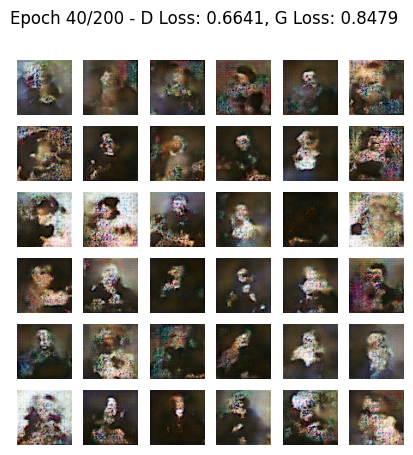

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 288ms/step - d_loss: 0.6642 - g_loss: 0.8506
Epoch 41/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - d_loss: 0.6694 - g_loss: 0.8521
Epoch 42/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6702 - g_loss: 0.8491
Epoch 43/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6658 - g_loss: 0.8321
Epoch 44/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6700 - g_loss: 0.8432
Epoch 45/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6784 - g_loss: 0.8298
Epoch 46/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6644 - g_loss: 0.8339
Epoch 47/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6676 - g_loss: 0.8333
Epoch 48/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6809 - g_loss: 0.8747
Epoch 49/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6641 - g_loss: 0.8339
Epoch 50/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - d_loss: 0.6687 - g_loss: 0.8536
Epoch 51/200

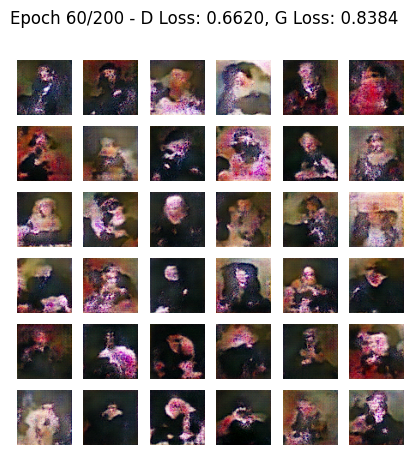

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 290ms/step - d_loss: 0.6605 - g_loss: 0.8323
Epoch 61/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - d_loss: 0.6624 - g_loss: 0.8462
Epoch 62/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6588 - g_loss: 0.8344
Epoch 63/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6606 - g_loss: 0.8415
Epoch 64/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6570 - g_loss: 0.8409
Epoch 65/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6565 - g_loss: 0.8444
Epoch 66/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6566 - g_loss: 0.8458
Epoch 67/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6657 - g_loss: 0.8555
Epoch 68/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6558 - g_loss: 0.8411
Epoch 69/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6544 - g_loss: 0.8339
Epoch 70/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6543 - g_loss: 0.8472
Epoch 71/200

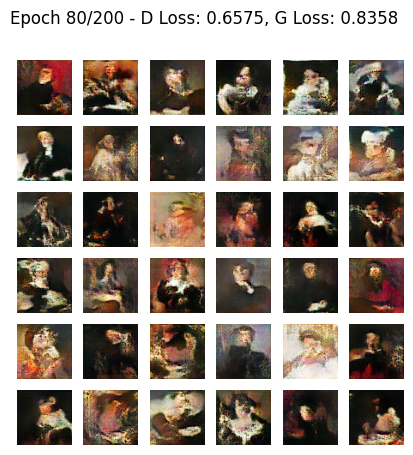

129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - d_loss: 0.6586 - g_loss: 0.8299
Epoch 81/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6576 - g_loss: 0.8299
Epoch 82/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6584 - g_loss: 0.8342
Epoch 83/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6576 - g_loss: 0.8400
Epoch 84/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6615 - g_loss: 0.8442
Epoch 85/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - d_loss: 0.6638 - g_loss: 0.8448
Epoch 86/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6616 - g_loss: 0.8264
Epoch 87/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6576 - g_loss: 0.8311
Epoch 88/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6604 - g_loss: 0.8310
Epoch 89/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6583 - g_loss: 0.8299
Epoch 90/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6565 - g_loss: 0.8293
Epoch 91/200

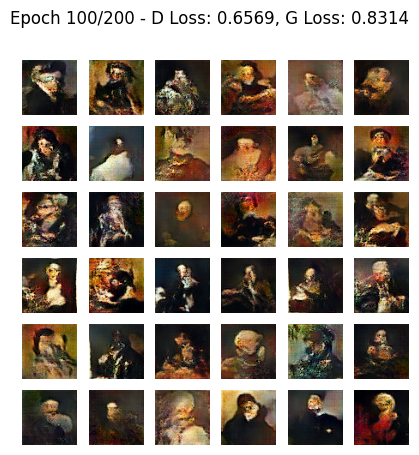

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - d_loss: 0.6576 - g_loss: 0.8269
Epoch 101/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6617 - g_loss: 0.8485
Epoch 102/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6592 - g_loss: 0.8584
Epoch 103/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6560 - g_loss: 0.8281
Epoch 104/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6577 - g_loss: 0.8292
Epoch 105/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6565 - g_loss: 0.8327
Epoch 106/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6557 - g_loss: 0.8252
Epoch 107/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6536 - g_loss: 0.8312
Epoch 108/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6584 - g_loss: 0.8229
Epoch 109/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6552 - g_loss: 0.8313
Epoch 110/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6536 - g_loss: 0.8270
Ep

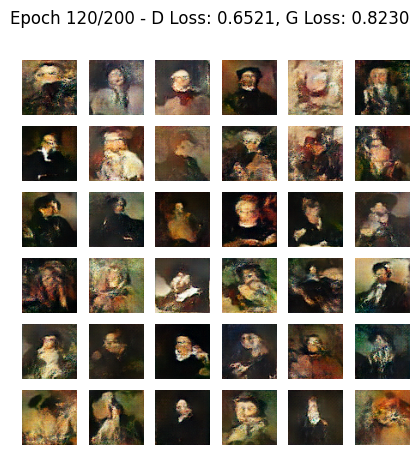

129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - d_loss: 0.6519 - g_loss: 0.8244
Epoch 121/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - d_loss: 0.6520 - g_loss: 0.8277
Epoch 122/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6532 - g_loss: 0.8320
Epoch 123/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6534 - g_loss: 0.8312
Epoch 124/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6535 - g_loss: 0.8243
Epoch 125/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6543 - g_loss: 0.8308
Epoch 126/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6511 - g_loss: 0.8302
Epoch 127/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6630 - g_loss: 0.8273
Epoch 128/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6580 - g_loss: 0.8607
Epoch 129/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6534 - g_loss: 0.8243
Epoch 130/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6487 - g_loss: 0.8392
Ep

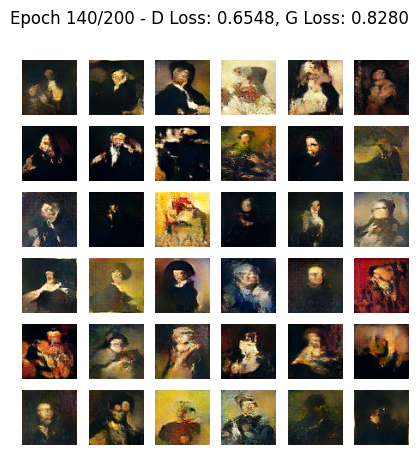

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 291ms/step - d_loss: 0.6534 - g_loss: 0.8240
Epoch 141/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - d_loss: 0.6459 - g_loss: 0.8201
Epoch 142/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6542 - g_loss: 0.8363
Epoch 143/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6490 - g_loss: 0.8181
Epoch 144/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6493 - g_loss: 0.8252
Epoch 145/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - d_loss: 0.6472 - g_loss: 0.8283
Epoch 146/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6522 - g_loss: 0.8552
Epoch 147/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6555 - g_loss: 0.8314
Epoch 148/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6489 - g_loss: 0.8347
Epoch 149/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6487 - g_loss: 0.8217
Epoch 150/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6464 - g_loss: 0.8268
Ep

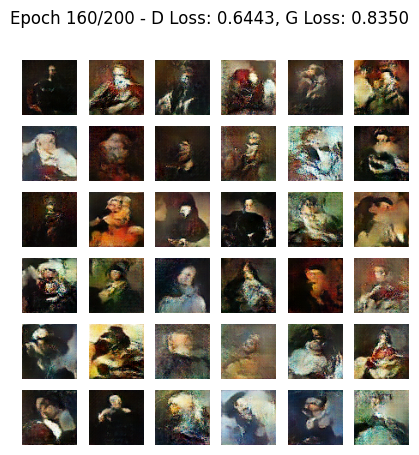

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 288ms/step - d_loss: 0.6482 - g_loss: 0.8482
Epoch 161/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6430 - g_loss: 0.8296
Epoch 162/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6441 - g_loss: 0.8266
Epoch 163/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6474 - g_loss: 0.8403
Epoch 164/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6460 - g_loss: 0.8171
Epoch 165/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6433 - g_loss: 0.8329
Epoch 166/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6541 - g_loss: 0.8693
Epoch 167/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6410 - g_loss: 0.8448
Epoch 168/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6465 - g_loss: 0.8400
Epoch 169/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6445 - g_loss: 0.8251
Epoch 170/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6441 - g_loss: 0.8297
Ep

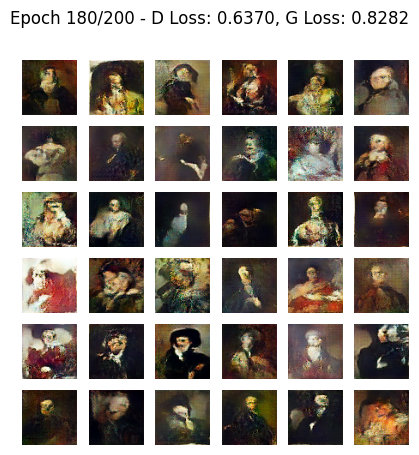

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 291ms/step - d_loss: 0.6370 - g_loss: 0.8232
Epoch 181/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - d_loss: 0.6382 - g_loss: 0.8245
Epoch 182/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6367 - g_loss: 0.8237
Epoch 183/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6401 - g_loss: 0.8321
Epoch 184/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6362 - g_loss: 0.8293
Epoch 185/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6359 - g_loss: 0.8341
Epoch 186/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6366 - g_loss: 0.8382
Epoch 187/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6373 - g_loss: 0.8270
Epoch 188/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6375 - g_loss: 0.8243
Epoch 189/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - d_loss: 0.6362 - g_loss: 0.8271
Epoch 190/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - d_loss: 0.6428 - g_loss: 0.8356
Ep

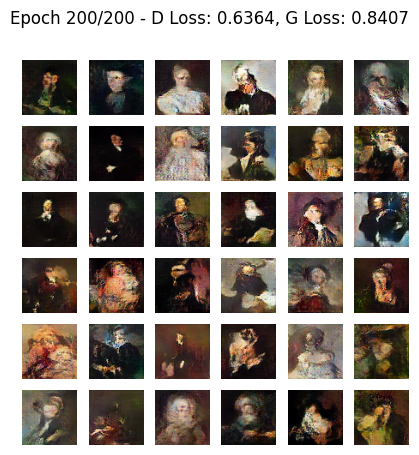

129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - d_loss: 0.6372 - g_loss: 0.8341


In [10]:
epochs = 200
batch_size = 32
initial_learning_rate = 0.0001
decay_steps = 1000
decay_rate = 0.95
epsilon = 1e-07

d_learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)
g_learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=d_learning_rate_schedule, epsilon=epsilon),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=g_learning_rate_schedule, epsilon=epsilon),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

image_callback = ImageGeneratorCallback(latent_dim)
history = gan.fit(dataset, epochs=epochs, batch_size=batch_size, callbacks=[image_callback])

<font color='red'>Ignore the below code as i wanted all the images at each step for my further process...</font>

In [11]:
# Save generated images to a zip file
zip_buffer = io.BytesIO()
with zipfile.ZipFile(zip_buffer, 'a', zipfile.ZIP_DEFLATED, False) as zip_file:
    for epoch, generated_images in enumerate(image_callback.generated_images, start=1):
        fig, axs = plt.subplots(6, 6, figsize=(10, 10))
        for i in range(6):
            for j in range(6):
                axs[i, j].imshow(generated_images[i * 6 + j])
                axs[i, j].axis('off')
        
        plt.suptitle(f"Epoch {epoch}/{epochs}")
        plt.savefig(f"epoch_{epoch}_images.png")
        plt.close()
        
        zip_file.write(f"epoch_{epoch}_images.png")
        os.remove(f"epoch_{epoch}_images.png")

# Save the zip buffer to a file
with open("generated_images.zip", "wb") as f:
    f.write(zip_buffer.getvalue())

# <font color="#B59410">Conclusion and Results</font>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


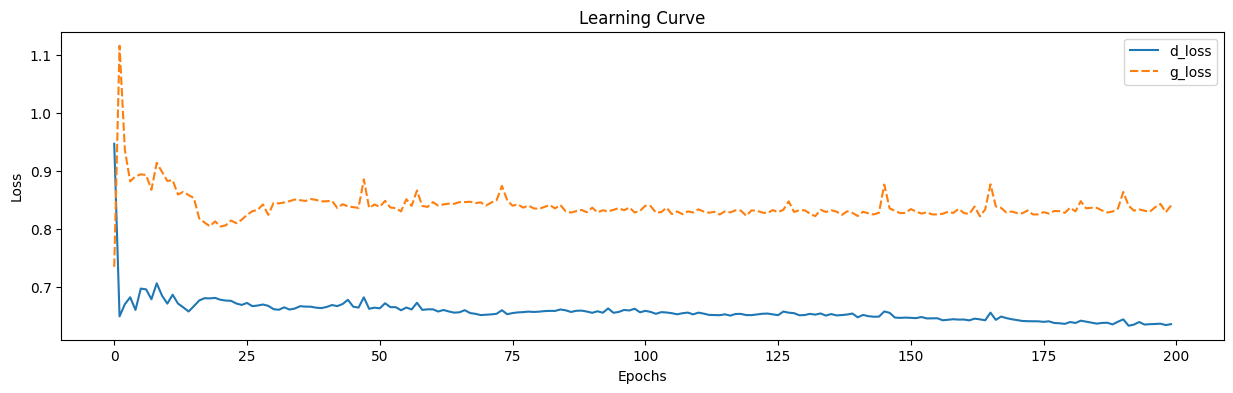

In [12]:
# Plotting the learning curve
fig = plt.figure(figsize=(15, 4))
ax = sns.lineplot(data=history.history)
ax.set(xlabel="Epochs")
ax.set(ylabel="Loss")
ax.set_title("Learning Curve")
plt.show()

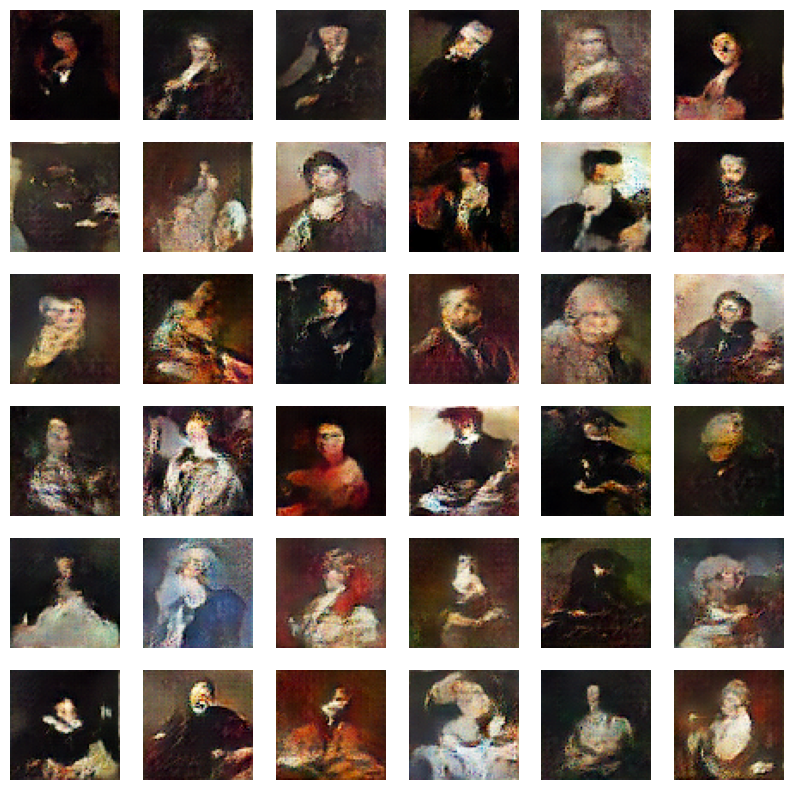

In [13]:
num_images=36

# Generate images using the trained generator
generated_images = generator(tf.random.normal([num_images, latent_dim]), training=False)

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(num_images//6, num_images//6, i+1)
    plt.imshow(generated_images[i], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.show()

<--------------------------------------------------------- END --------------------------------------------------------->